<div style="background-color: powderblue; padding: 10px; border-radius: 15px;">
    <h1 style="text-align: center; font-size: 28px;">🏁 Setting the stage 🎌</h1>
</div>

In [1]:
!pip install "/kaggle/input/autocorrect/autocorrect-2.6.1.tar"
!pip install "/kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl"

Processing /kaggle/input/autocorrect/autocorrect-2.6.1.tar
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=65b6fc248192fb6492f763558f9a94a5a82a904f5a91c90918670571f16552f0
  Stored in directory: /root/.cache/pip/wheels/db/69/42/0fb0421d2fe70d195a04665edc760cfe5fd341d7bb8d8e0aaa
Successfully built autocorrect
Processing /kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np 
import pandas as pd
import string
from collections import Counter
import re
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from autocorrect import Speller
from spellchecker import SpellChecker

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

import optuna
import lightgbm as lgb

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch import nn
import torch.optim as optim
from transformers import DataCollatorWithPadding, AutoModel, AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup, Trainer, TrainingArguments

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#Train
prompts = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv')
summaries = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv')
df = prompts.merge(summaries, on = ['prompt_id'],how ='left')

#Test
prompts_test = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv')
summaries_test = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv')
test = prompts_test.merge(summaries_test, on = ['prompt_id'],how ='left')

In [4]:
df.head()

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00791789cc1f,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415
1,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0086ef22de8f,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058
2,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0094589c7a22,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181
3,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00cd5736026a,One element of an Ideal tragedy is having a co...,0.088882,-0.594710
4,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00d98b8ff756,The 3 ideal of tragedy is how complex you need...,-0.687288,-0.460886


In [5]:
test.head()

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text
0,abc123,Summarize...,Example Title 1,Heading\nText...,000000ffffff,Example text 1
1,abc123,Summarize...,Example Title 1,Heading\nText...,222222cccccc,Example text 3
2,def789,Summarize...,Example Title 2,Heading\nText...,111111eeeeee,Example text 2
3,def789,Summarize...,Example Title 2,Heading\nText...,333333dddddd,Example text 4


<div style="background-color: #c4affa; padding: 10px; border-radius: 15px;">
    <h1 style="text-align: center; font-size: 28px;">🧹 Data Cleaning & Processing ⚙️</h1>
</div>

In [6]:
spell = Speller(lang='en')
df["correct_text"] = df['text'].apply(lambda x: "".join([spell(i) for i in x]))
test["correct_text"] = test['text'].apply(lambda x: "".join([spell(i) for i in x]))
df['prompt_text'] = df['prompt_text'].apply(lambda x: "".join([spell(i) for i in x]))
test['prompt_text'] = test['prompt_text'].apply(lambda x: "".join([spell(i) for i in x]))

In [7]:
df.head()

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording,correct_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00791789cc1f,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415,1 element of an ideal tragedy is that it shoul...
1,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0086ef22de8f,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058,The three elements of an ideal tragedy are: H...
2,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0094589c7a22,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181,Aristotle states that an ideal tragedy should ...
3,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00cd5736026a,One element of an Ideal tragedy is having a co...,0.088882,-0.594710,One element of an Ideal tragedy is having a co...
4,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00d98b8ff756,The 3 ideal of tragedy is how complex you need...,-0.687288,-0.460886,The 3 ideal of tragedy is how complex you need...


In [8]:
# spell = Speller(lang='en')

# df['correct_text'] = df['text'].apply(lambda x: "".join([spell(i) for i in x]))
# test['correct_text'] = test['text'].apply(lambda x: "".join([spell(i) for i in x]))

# def clean_text(text):
#     text = text.lower()
#     text = re.sub(r'\n', ' ', text)
#     text = re.sub(r'\W', ' ', text)
#     text = re.sub(r'\s+', ' ', text)
#     return text


# df['correct_text'] = df['text'].apply(lambda x: "".join([spell(i) for i in x]))
# test['correct_text'] = test['text'].apply(lambda x: "".join([spell(i) for i in x]))

# df['prompt_text'] = df['prompt_text'].apply(lambda x: "".join([spell(i) for i in x]))
# test['prompt_text'] = test['prompt_text'].apply(lambda x: "".join([spell(i) for i in x]))

In [9]:
df.head()

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording,correct_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00791789cc1f,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415,1 element of an ideal tragedy is that it shoul...
1,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0086ef22de8f,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058,The three elements of an ideal tragedy are: H...
2,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0094589c7a22,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181,Aristotle states that an ideal tragedy should ...
3,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00cd5736026a,One element of an Ideal tragedy is having a co...,0.088882,-0.594710,One element of an Ideal tragedy is having a co...
4,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00d98b8ff756,The 3 ideal of tragedy is how complex you need...,-0.687288,-0.460886,The 3 ideal of tragedy is how complex you need...


<div style="background-color: #ea9bc4; padding: 10px; border-radius: 15px;">
    <h1 style="text-align: center; font-size: 28px;">  🧑‍🔬 Feature Engineering 👨‍🔬</h1>
</div>

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 0</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> Deberta V3 predictions</h1></div>

In [10]:
model_name = "/kaggle/input/deberta-v3-base/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2,problem_type="regression")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/deberta-v3-base/deberta-v3-base and are newly initialized: ['pooler.dense.bias', 'classifier.bias', 'classifier.weight', 'pooler.dense.weight']
You sho

In [11]:
# model_name = "/kaggle/input/deberta-v3-base/deberta-v3-base"

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, problem_type="regression")

In [12]:
# class CustomDataset(Dataset):
#     def __init__(self, df, has_labels=True):
#         self.df=df
#         self.prompt_titles = df["question"].values.tolist()
#         self.texts = df["correct_text"].values.tolist()
#         self.encoded_examples = tokenizer(
#             text=self.prompt_titles,
#             text_pair=self.texts,
#             truncation=True,
#             padding=True,
#             max_length=512,
#             return_tensors="pt"
#         )
        
#         self.has_labels = has_labels
#         if self.has_labels:
#             self.labels_list = df[["content", "wording"]].values.tolist()
    
#     def __len__(self):
#         return len(self.df)
    
#     def __getitem__(self,idx):
#         item = {
#             "input_ids" : self.encoded_examples["input_ids"][idx],
#             "attention_mask" : self.encoded_examples["attention_mask"][idx],
#             "token_type_ids" : self.encoded_examples["token_type_ids"][idx]
#         }
#         if self.has_labels:
#             item["labels"] = torch.tensor(self.labels_list[idx])
        
#         return item

In [13]:
class CustomDataset(Dataset):
    def __init__(self, df, has_labels=True):
        self.df = df
        self.prompt_titles = df["question"].values.tolist()
        self.texts = df["correct_text"].values.tolist()
        self.encoded_examples = tokenizer(
            text=self.prompt_titles,
            text_pair=self.texts,
            truncation=True,
            padding=True,
            max_length=512,
            return_tensors="pt"
        )
        self.has_labels = has_labels
        
        if self.has_labels:
            self.labels_list = df[["content", "wording"]].values.tolist()
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = {
            "input_ids": self.encoded_examples["input_ids"][idx],
            "attention_mask": self.encoded_examples["attention_mask"][idx],
            "token_type_ids": self.encoded_examples["token_type_ids"][idx]
        }
        
        if self.has_labels:
            item["labels"] = torch.tensor(self.labels_list[idx])
        
        return item

In [14]:
def compute_mcrmse(eval_pred):

    predictions, labels = eval_pred
    squared_errors = np.square(predictions - labels)
    mean_squared_errors = np.mean(squared_errors, axis=0)
    
    rmse = np.sqrt(mean_squared_errors)
    
    mcrmse_value = np.mean(rmse)
    
    content_rmse = rmse[0]
    wording_rmse = rmse[1]
    
    return {
        "mcrmse": mcrmse_value,
        "content_rmse": content_rmse,
        "wording_rmse": wording_rmse
    }

In [15]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, KFold,GroupKFold
from sklearn.metrics import mean_squared_error
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel,AutoConfig
import transformers
from transformers import RobertaModel,RobertaTokenizer

from transformers import AlbertModel,AlbertTokenizer
from transformers import XLNetModel,XLNetTokenizer,XLNetConfig
from transformers import DebertaModel, DebertaTokenizer
from transformers import ElectraModel, ElectraTokenizer, ElectraForSequenceClassification
from transformers import BartModel,BertModel,BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import MPNetModel,MPNetTokenizer
from transformers import FunnelBaseModel,FunnelTokenizer,FunnelModel
from transformers import GPT2Model, GPT2Tokenizer, GPT2Config
from transformers import T5EncoderModel,T5Tokenizer
import logging
import sys
from contextlib import contextmanager
import time
import random
from tqdm import tqdm
import os
import pickle
import gc
SEED=42
set_seed(SEED)

In [17]:
df['question'] = df["prompt_title"] + "\n" + df["prompt_question"] + "\n" + df["prompt_text"]
test['question'] = test["prompt_title"] + "\n" + test["prompt_question"] + "\n" + test["prompt_text"]

In [18]:
df.head()

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording,correct_text,question
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00791789cc1f,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415,1 element of an ideal tragedy is that it shoul...,On Tragedy\nSummarize at least 3 elements of a...
1,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0086ef22de8f,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058,The three elements of an ideal tragedy are: H...,On Tragedy\nSummarize at least 3 elements of a...
2,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,0094589c7a22,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181,Aristotle states that an ideal tragedy should ...,On Tragedy\nSummarize at least 3 elements of a...
3,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00cd5736026a,One element of an Ideal tragedy is having a co...,0.088882,-0.594710,One element of an Ideal tragedy is having a co...,On Tragedy\nSummarize at least 3 elements of a...
4,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,00d98b8ff756,The 3 ideal of tragedy is how complex you need...,-0.687288,-0.460886,The 3 ideal of tragedy is how complex you need...,On Tragedy\nSummarize at least 3 elements of a...


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

df['question'] = df["prompt_title"] + "\n" + df["prompt_question"] + "\n" + df["prompt_text"]
test['question'] = test["prompt_title"] + "\n" + test["prompt_question"] + "\n" + test["prompt_text"]


def train_deberta(df, test):

    df_train, df_valid = train_test_split(df, test_size=0.2, random_state=2023)

    train_dataset = CustomDataset(df_train)
    valid_dataset = CustomDataset(df_valid)
    test_dataset  = CustomDataset(test, has_labels=False)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    training_args = TrainingArguments(
        output_dir="output",             
        per_device_train_batch_size=4,   
        per_device_eval_batch_size=4,    
        learning_rate=1e-3,            
        lr_scheduler_type="linear",      
        warmup_ratio=0.01,               
        num_train_epochs=4,   
        save_strategy="epoch",           
        logging_strategy="epoch",        
        evaluation_strategy="epoch", 
        load_best_model_at_end=True,     
        metric_for_best_model="mcrmse",           
        fp16=True,                      
        report_to='none'
    )

    trainer = Trainer(
        model=model,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        data_collator=data_collator,
        args=training_args,
        compute_metrics=compute_mcrmse,
    )
    trainer.train()

    df_train = df_train.reset_index(drop = True)
    df_valid = df_valid.reset_index(drop = True)

    predictions_train = trainer.predict(train_dataset)
    deberta_content = predictions_train.predictions[:, 0].tolist()
    deberta_wording = predictions_train.predictions[:, 1].tolist()

    df_train['deberta_content'] = deberta_content
    df_train['deberta_wording'] = deberta_wording

    predictions_val = trainer.predict(valid_dataset)
    deberta_content = predictions_val.predictions[:, 0].tolist()
    deberta_wording = predictions_val.predictions[:, 1].tolist()

    df_valid['deberta_content'] = deberta_content
    df_valid['deberta_wording'] = deberta_wording

    predictions_test = trainer.predict(test_dataset)
    deberta_content = predictions_test.predictions[:, 0].tolist()
    deberta_wording = predictions_test.predictions[:, 1].tolist()
    
    test['deberta_content'] = deberta_content
    test['deberta_wording'] = deberta_wording
    
    df_train_val = pd.concat([df_train[['prompt_id','student_id','deberta_content','deberta_wording']], 
                          df_valid[['prompt_id','student_id','deberta_content','deberta_wording']]], ignore_index=True)
    
    return df_train_val, test


df_train_val, test = train_deberta(df, test)

cuda


You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Mcrmse,Content Rmse,Wording Rmse
1,1.111500,1.100505,1.049030,1.055488,1.042572
2,1.087600,1.107030,1.052136,1.058392,1.045881
3,1.084000,1.098795,1.048221,1.053596,1.042845
4,1.078600,1.098748,1.048197,1.053740,1.042654


In [20]:

# torch.manual_seed(42)
# random.seed(42)

In [21]:
df = df.merge(df_train_val, on = ['prompt_id','student_id'], how = 'left')

In [22]:
del df_train_val
gc.collect()

878

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 1</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> Ratio of No of words in Student's response vs context</h1></div>

In [23]:
def wordsRatio(context, response):
    context = context.split()
    response = response.split()
    return len(response)/len(context)

df["word_count_ratio"] = df.apply(lambda x: wordsRatio(x['prompt_text'], x['correct_text']), axis=1)
test["word_count_ratio"] = test.apply(lambda x: wordsRatio(x['prompt_text'], x['correct_text']), axis=1)

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 2</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> Number of spelling errors in Student's summary</h1></div>

In [24]:
def misspelledRatio(x):
    spell = SpellChecker()
    words = x.split()
    misspelled = spell.unknown(words)
    return len(misspelled)/len(words)

df["misspelled_ratio"] = df['text'].apply(lambda x: misspelledRatio(x))  
test["misspelled_ratio"] = test['text'].apply(lambda x: misspelledRatio(x))

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 3</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> Stop word Ratio in Student's summary</h1></div>

In [25]:
stop_words = stopwords.words('english')
def StopwordsRatio(context, response):
    length  = len(response.split())
    response = " ".join([i for i in response.split() if i in stop_words]) 
    return len(response)/length

df["stop_word_ratio"] = df.apply(lambda x: StopwordsRatio(x['prompt_text'], x['correct_text']), axis=1)
test["stop_word_ratio"] = test.apply(lambda x: StopwordsRatio(x['prompt_text'], x['correct_text']), axis=1)

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 4</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> Count of same words in Student's summary</h1></div>

In [26]:
def sameWordsRatio(context, response):
    context = " ".join([i for i in context.split() if i not in stop_words]) 
    response = " ".join([i for i in response.split() if i not in stop_words]) 
    return len(set(response).intersection(set(context)))/len(response)

df["same_word_ratio"] = df.apply(lambda x: sameWordsRatio(x['prompt_text'], x['correct_text']), axis=1)
test["same_word_ratio"] = test.apply(lambda x: sameWordsRatio(x['prompt_text'], x['correct_text']), axis=1)

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 5</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> Average reading speed in words per minute </h1></div>

In [27]:
# def readTime(x):
#     average_wpm = 200
#     word_count = len(x.split())
#     return word_count / average_wpm

# df["read_time"] = df['text'].apply(lambda x: readTime(x))  
# test["read_time"] = test['text'].apply(lambda x: readTime(x))  

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 6</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> Diversity of words in the Student's response </h1></div>

In [28]:
def diversityIndex(x):
    words = x.split()
    word_counts = Counter(words)
    total_words = len(words)
    return 1 - sum((count / total_words) ** 2 for count in word_counts.values())

df["diversity_index"] = df['text'].apply(lambda x: diversityIndex(x))  
test["diversity_index"] = test['text'].apply(lambda x: diversityIndex(x))  

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 7</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> TF IDF to identify most frequent words in context and response </h1></div>

In [29]:
def tfidfImportance(context, response):
    top_n = 10

    context = " ".join([i for i in context.split() if i not in stop_words]) 
    response = " ".join([i for i in response.split() if i not in stop_words]) 
    
    corpus = [
        context, response
     ]

    tfidf_unigram = TfidfVectorizer(ngram_range=(1, 1))
    tfidf_unigram_matrix = tfidf_unigram.fit_transform(corpus)
    unigram_feature_names = tfidf_unigram.get_feature_names_out()
    dense_unigram_array = tfidf_unigram_matrix.toarray()
    unigram_df = pd.DataFrame(data=dense_unigram_array, columns=unigram_feature_names)

    top_unigrams = []
    for index, row in unigram_df.iterrows():
        top_unigrams.append(list(row.nlargest(top_n).index))

    tfidf_bigram = TfidfVectorizer(ngram_range=(2, 2)) 

    tfidf_bigram_matrix = tfidf_bigram.fit_transform(corpus)
    bigram_feature_names = tfidf_bigram.get_feature_names_out()
    dense_bigram_array = tfidf_bigram_matrix.toarray()
    bigram_df = pd.DataFrame(data=dense_bigram_array, columns=bigram_feature_names)

    top_bigrams = []
    for index, row in bigram_df.iterrows():
        top_bigrams.append(list(row.nlargest(top_n).index))


    return len(set(top_unigrams[0]).intersection(set(top_unigrams[1])))/top_n, len(set(top_bigrams[0]).intersection(set(top_bigrams[1])))/top_n

df[['top_unigrams_ratio','top_bigrams_ratio']]= df.apply(lambda x: tfidfImportance(x['prompt_text'], x['correct_text']), axis=1, result_type ='expand')
test[['top_unigrams_ratio','top_bigrams_ratio']]= test.apply(lambda x: tfidfImportance(x['prompt_text'], x['correct_text']), axis=1, result_type ='expand')

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 8</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> Cosine similarity of context and response using TD IDF vectors</h1></div>

In [30]:
def tdidfSimilarity(context, response):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform([context, response])
    return cosine_similarity(vectors[0:1], vectors[1:2])[0][0] 

df['tfidf_similarity']= df.apply(lambda x: tdidfSimilarity(x['prompt_text'], x['correct_text']), axis=1)
test['tfidf_similarity']= test.apply(lambda x: tdidfSimilarity(x['prompt_text'], x['correct_text']), axis=1)

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 9</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> N Grams Co occurence context and response </h1></div>

In [31]:
def tokenize(sentence):
    sentence = re.sub(r'[^\w\s]', '', sentence.lower())
    tokens = sentence.split()
    return tokens

def generate_ngrams(tokens, n):
    ngrams = []
    for i in range(len(tokens) - n + 1):
        ngram = tuple(tokens[i:i + n])
        ngrams.append(ngram)
    return ngrams


def cooccurrenceRatio(context, response, n_gram_size = 2):
    tokens1 = tokenize(context)
    tokens2 = tokenize(response)

    ngrams1 = generate_ngrams(tokens1, n_gram_size)
    ngrams2 = generate_ngrams(tokens2, n_gram_size)

    co_occurrence_count = len(set(ngrams1) & set(ngrams2))
    
    return co_occurrence_count/(min(len(ngrams1),len(ngrams2))+1)

df['bi_gram_ratio'] = df.apply(lambda x: cooccurrenceRatio(x['prompt_text'], x['correct_text']), axis=1)
test['bi_gram_ratio'] = test.apply(lambda x: cooccurrenceRatio(x['prompt_text'], x['correct_text']), axis=1)

df['tri_gram_ratio'] = df.apply(lambda x: cooccurrenceRatio(x['prompt_text'], x['correct_text'], n_gram_size = 3), axis=1)
test['tri_gram_ratio'] = test.apply(lambda x: cooccurrenceRatio(x['prompt_text'], x['correct_text'],n_gram_size = 3 ), axis=1)

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 10</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> Check punctuation in Student's response </h1></div>

In [32]:
def checkPunctuations(x):
    punctuation_count = 0

    for char in x:
        if char in string.punctuation:
            punctuation_count += 1
    return punctuation_count/len(x.split())

df["punctuation_ratio"] = df['text'].apply(lambda x: checkPunctuations(x))
test["punctuation_ratio"] = test['text'].apply(lambda x: checkPunctuations(x)) 

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 11</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> Identifying Co occurences of NER in context and response </h1></div>

In [33]:
nlp = spacy.load("en_core_web_sm")

def nerCooccurrenceRatio(context, response, n_gram_size = 2):
    
    doc1 = nlp(context)
    doc2 = nlp(response)
    
    entities1 = {ent.text for ent in doc1.ents}      
    entities2 = {ent.text for ent in doc2.ents}       
    
    overlap_entities = entities1.intersection(entities2)
    return len(overlap_entities)/(min(len(entities1),len(entities2))+1)


df['nercooccurrence_ratio'] = df.apply(lambda x: nerCooccurrenceRatio(x['prompt_text'], x['correct_text']), axis=1)
test['nercooccurrence_ratio'] = test.apply(lambda x: nerCooccurrenceRatio(x['prompt_text'], x['correct_text']), axis=1)

<div style="background-color: #b6d7a8; padding: 10px; border-radius: 15px;">
    <h1 style="text-align: center; font-size: 28px;"> 🔬 EDA ⚗️</h1>
</div>

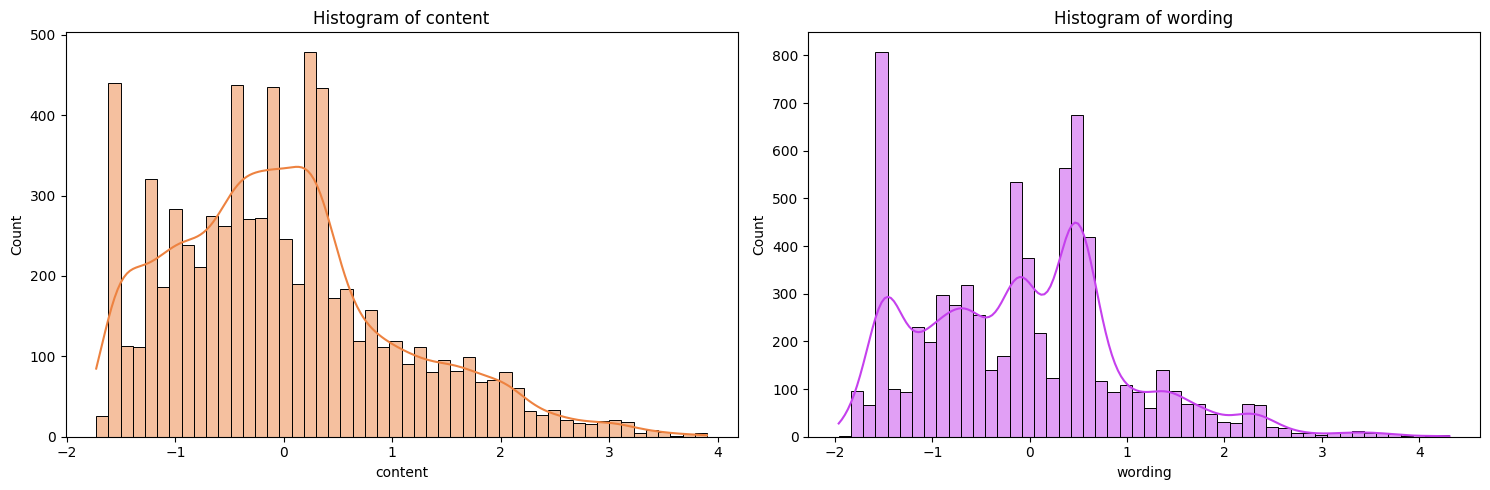

In [34]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2, 1)  
sns.histplot(x=df['content'], bins=50, kde=True, color='#ed8240')
plt.title(f"Histogram of content")

plt.subplot(1,2, 2)  
sns.histplot(x=df['wording'], bins=50, kde=True, color='#c540ed')
plt.title(f"Histogram of wording")

plt.tight_layout() 
plt.show()

In [35]:
cols = [
    'deberta_content',
    'deberta_wording',
    'word_count_ratio', 
    'misspelled_ratio', 
    'stop_word_ratio',
    'same_word_ratio', 
#     'read_time', 
    'diversity_index', 
    'top_unigrams_ratio',
    'top_bigrams_ratio',
    'tfidf_similarity',
    'punctuation_ratio', 
    'bi_gram_ratio',
    'tri_gram_ratio', 
    'nercooccurrence_ratio'
]

<Axes: >

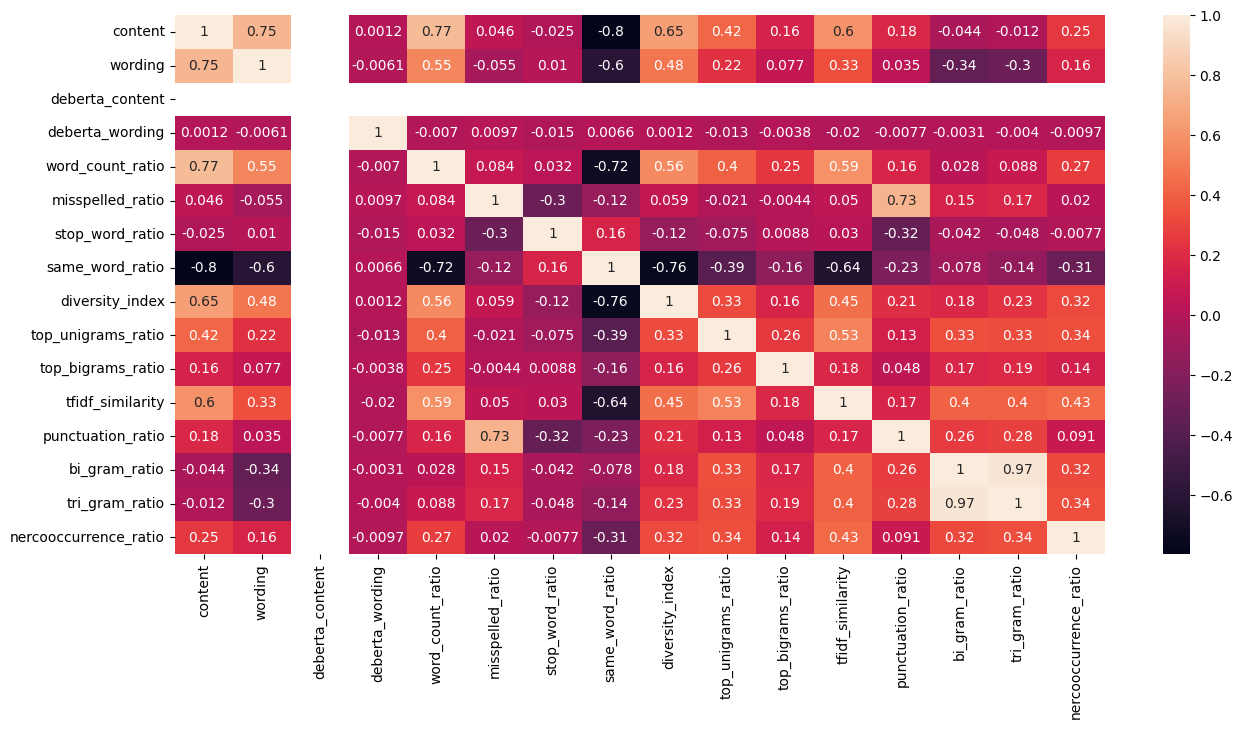

In [36]:
all_cols = ['content','wording'] + cols
plt.figure(figsize=(15, 7))
sns.heatmap(df[all_cols].corr(), annot=True)

Plots for deberta_content


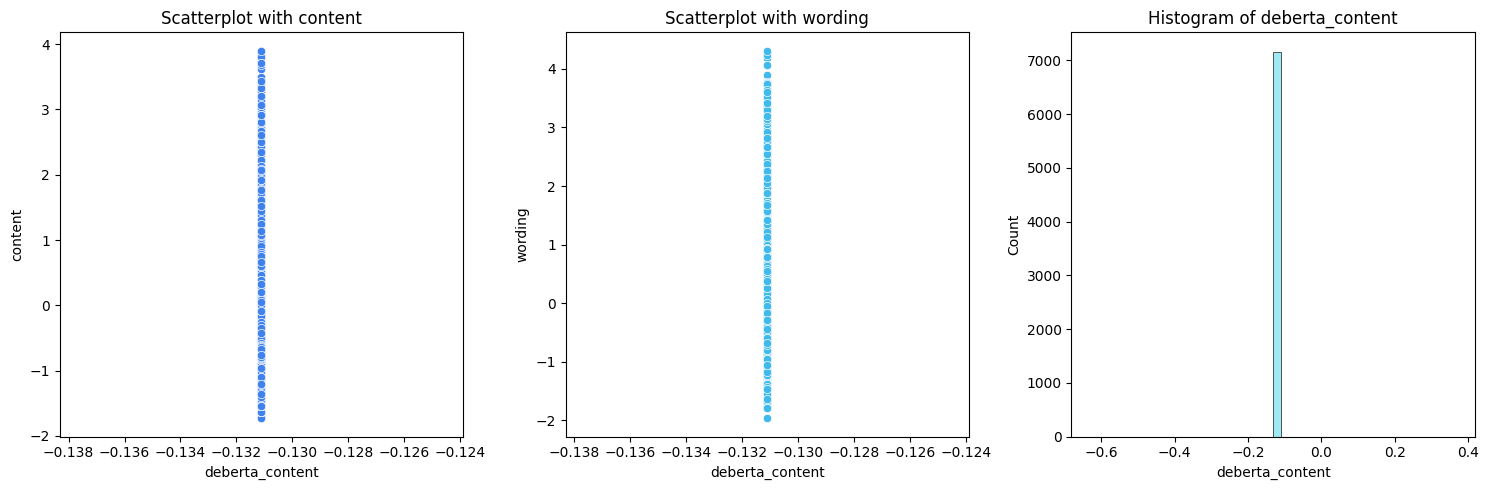

Plots for deberta_wording


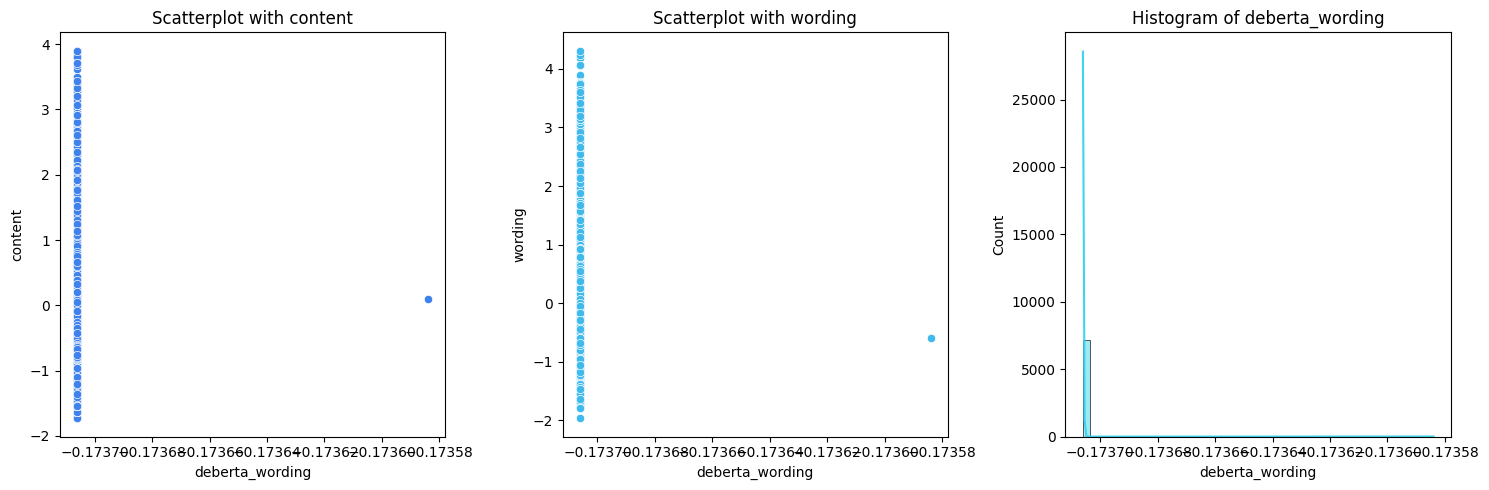

Plots for word_count_ratio


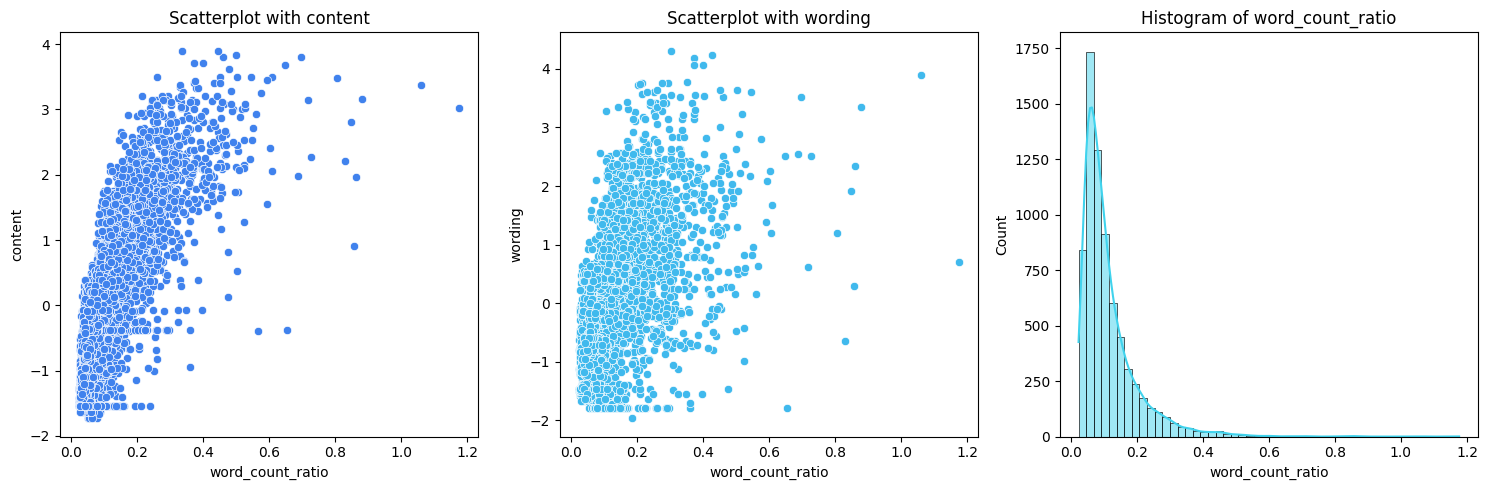

Plots for misspelled_ratio


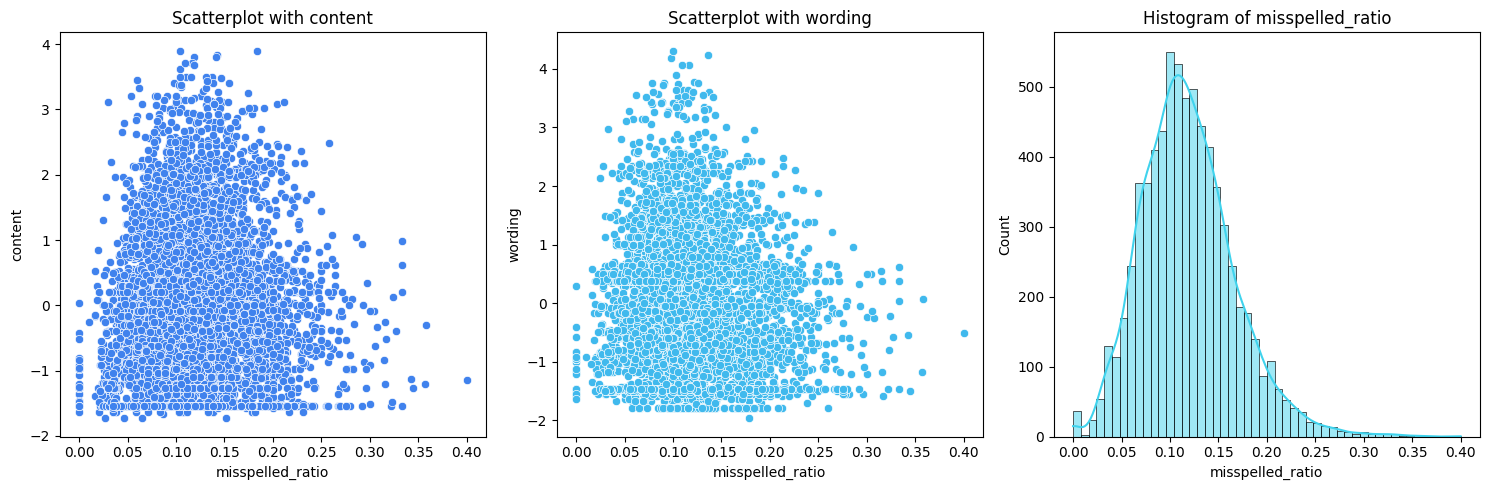

Plots for stop_word_ratio


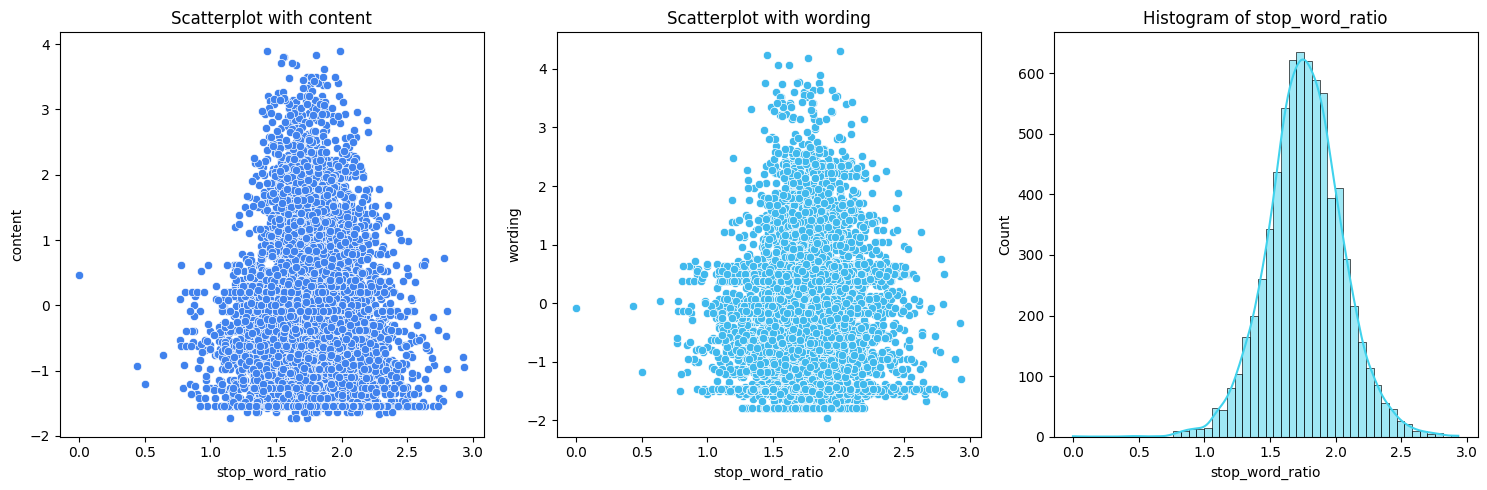

Plots for same_word_ratio


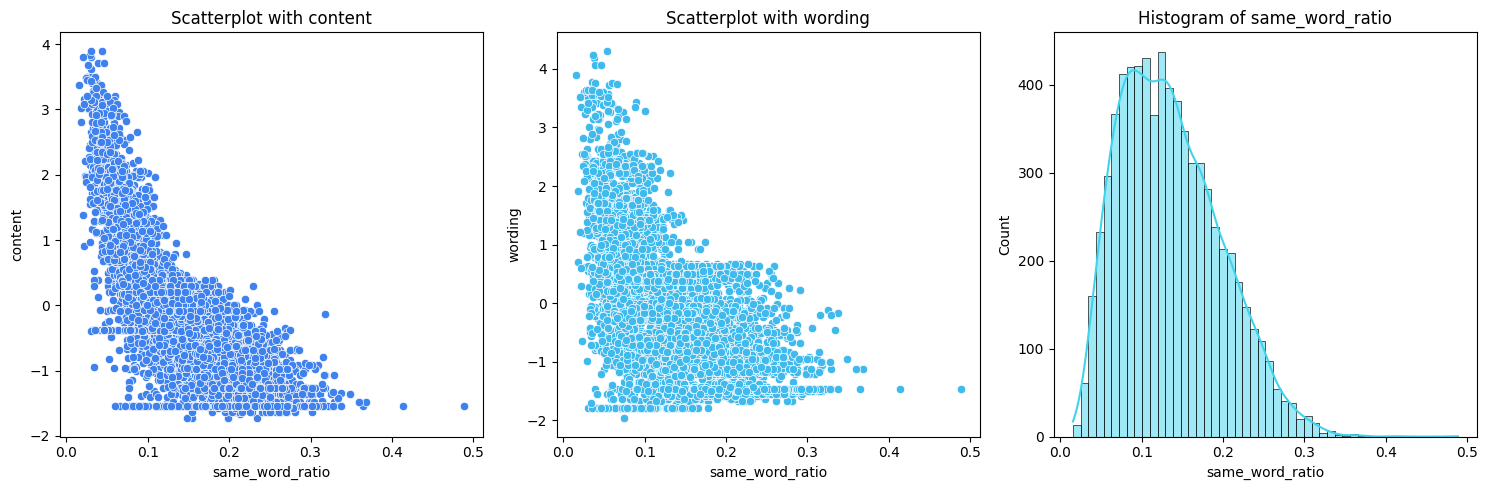

Plots for diversity_index


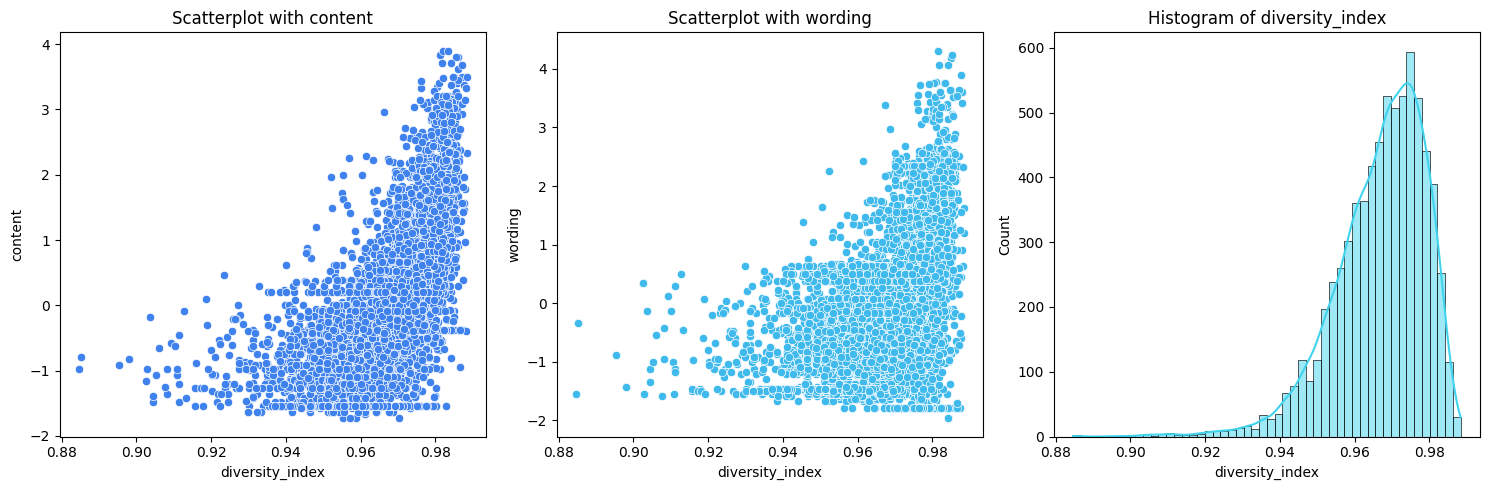

Plots for top_unigrams_ratio


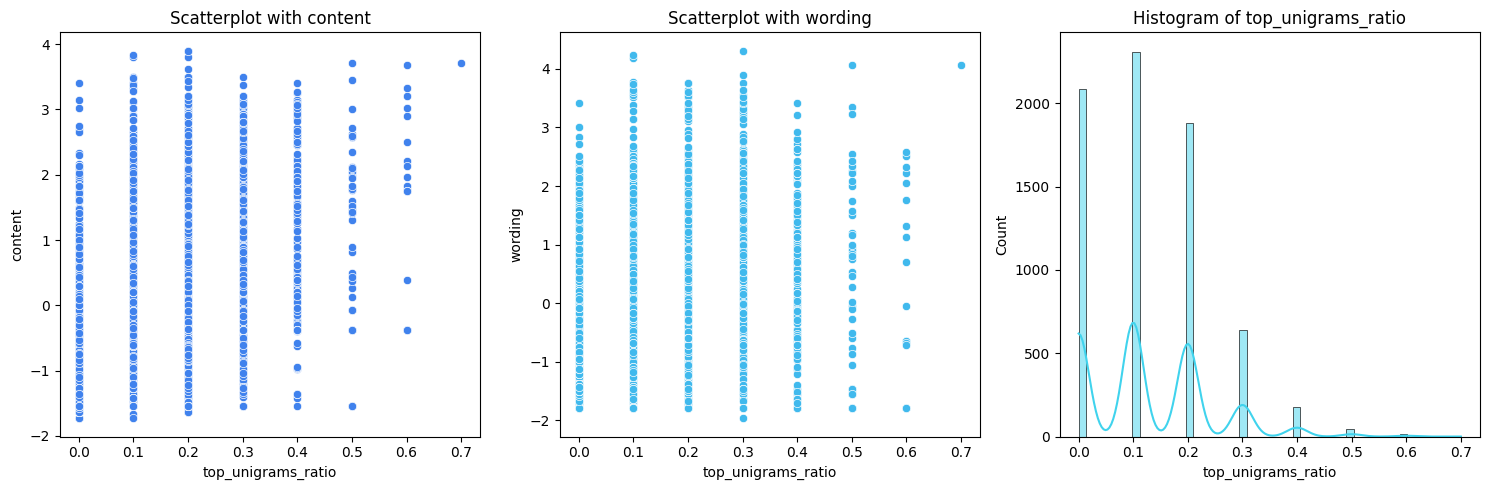

Plots for top_bigrams_ratio


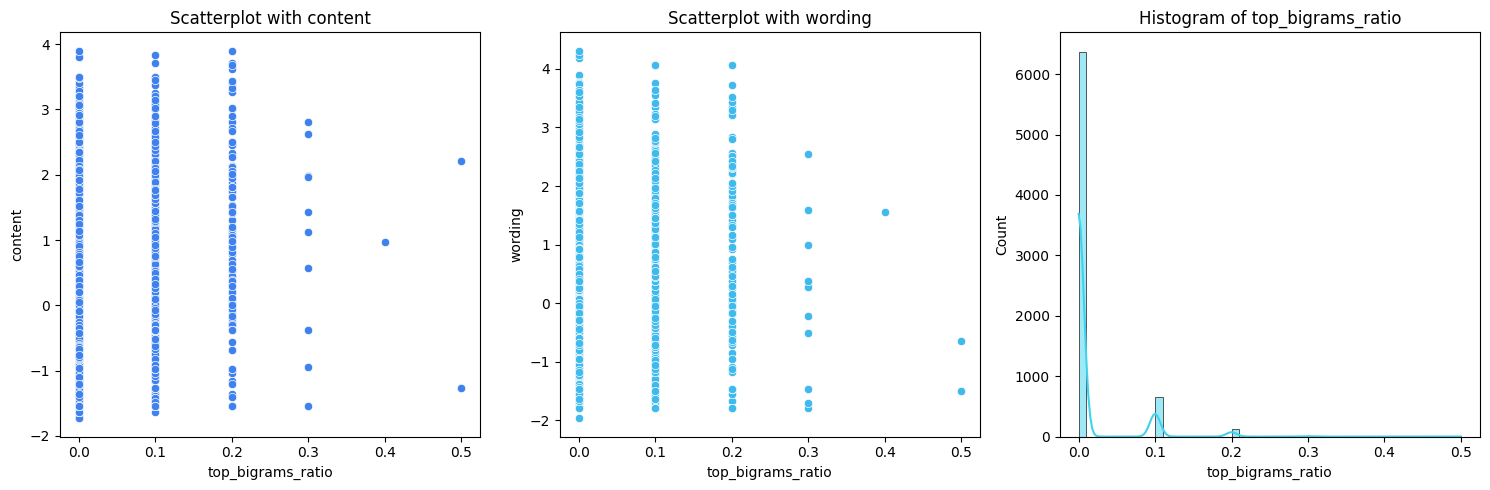

Plots for tfidf_similarity


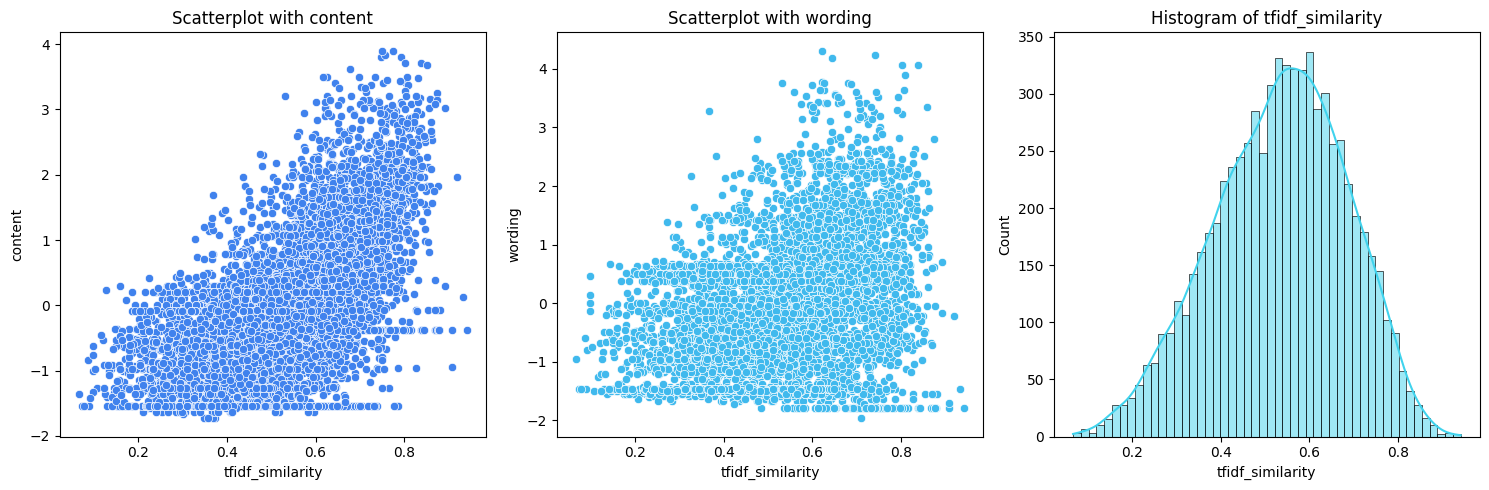

Plots for punctuation_ratio


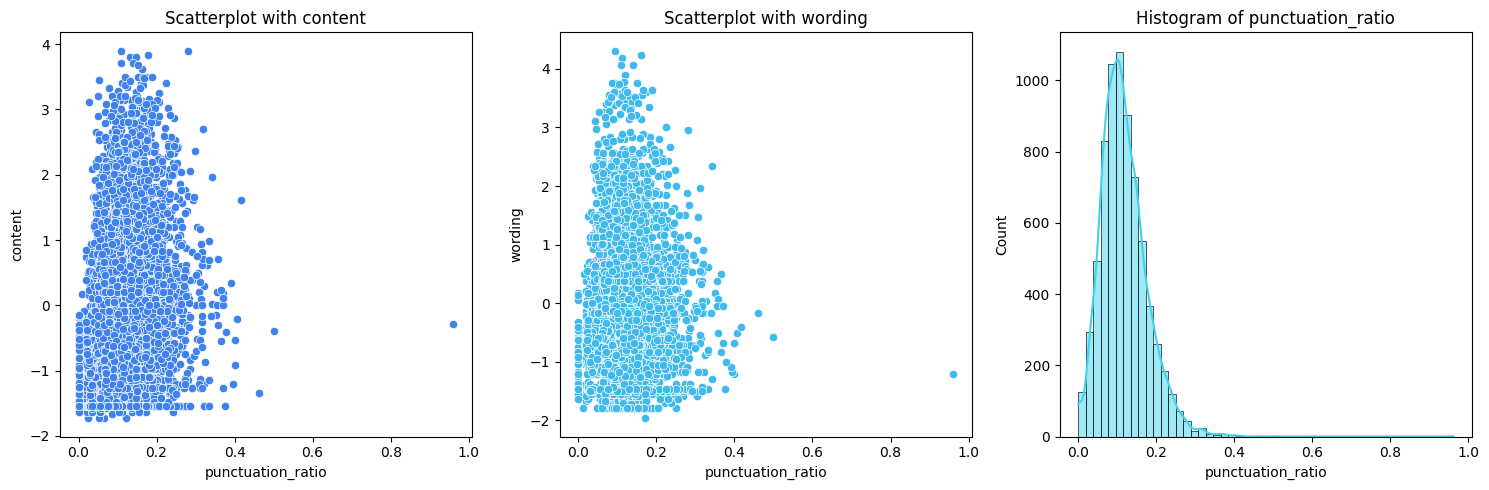

Plots for bi_gram_ratio


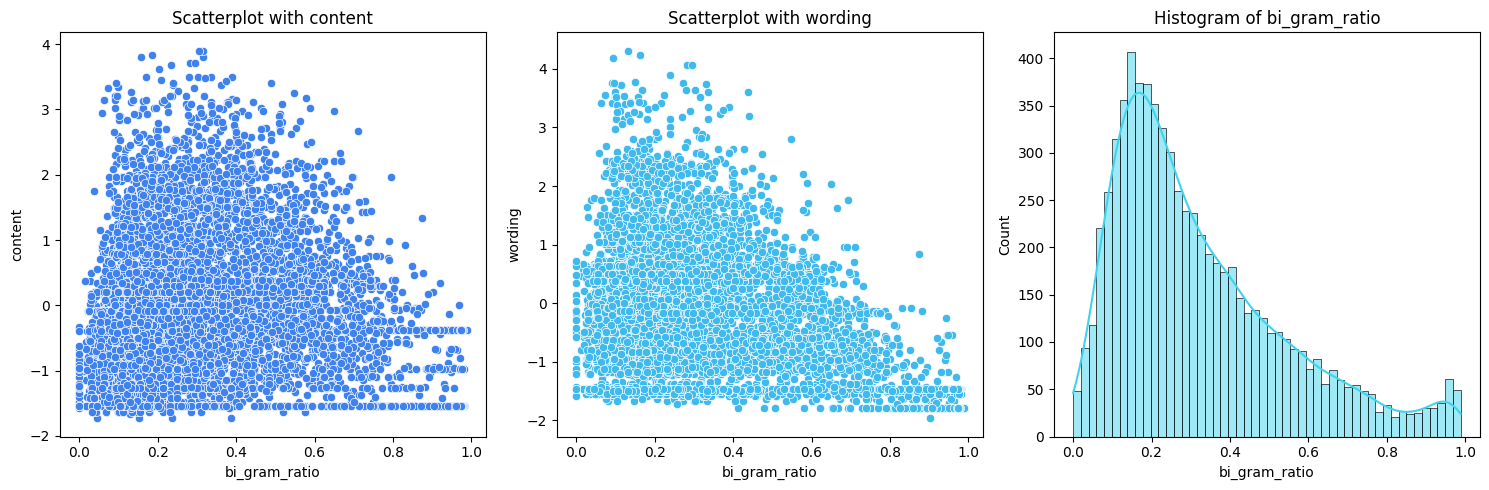

Plots for tri_gram_ratio


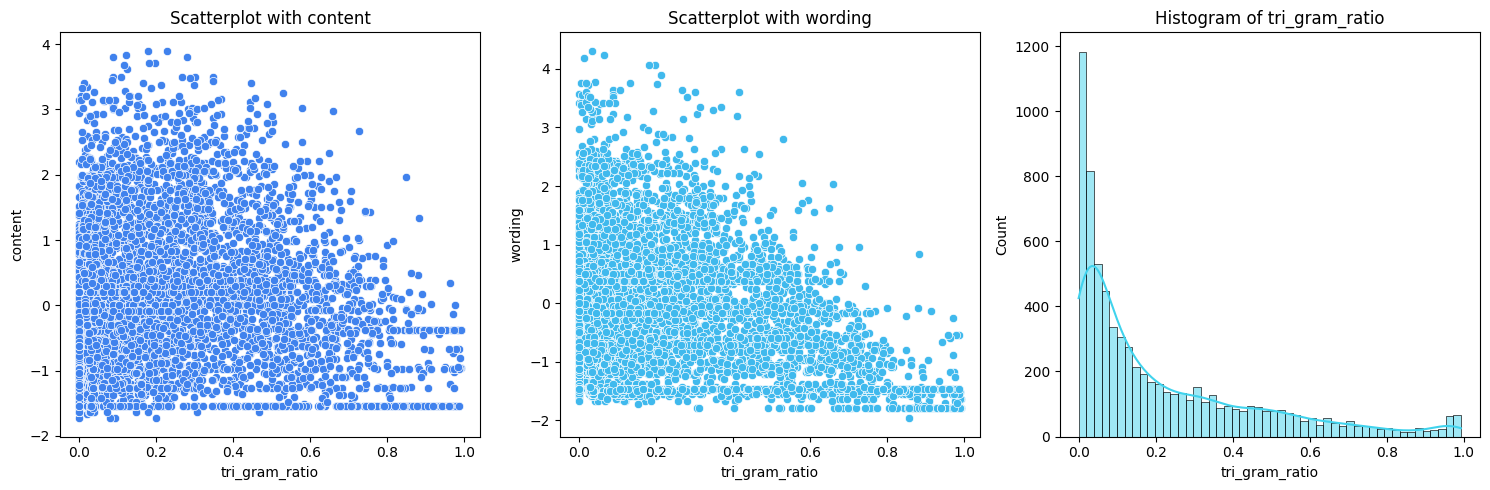

Plots for nercooccurrence_ratio


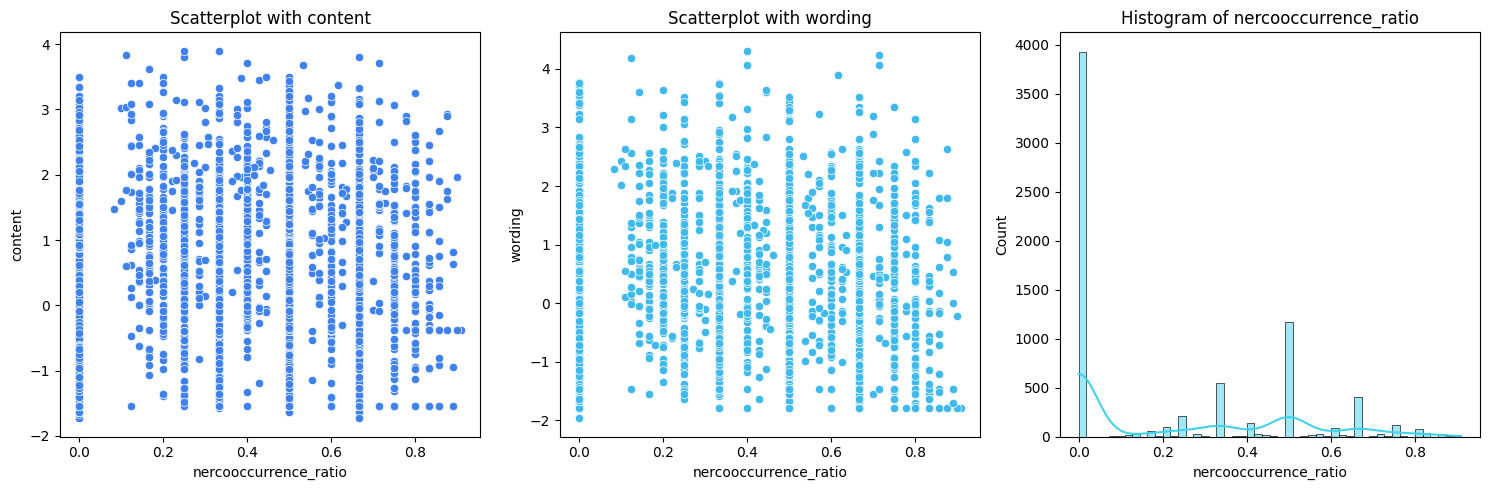

In [37]:
for col in cols:
    print(f'Plots for {col}')
    plt.figure(figsize=(15, 5))

    plt.subplot(1,3, 1)  
    sns.scatterplot(x=df[col], y=df['content'], color='#4082ed')
    plt.title("Scatterplot with content")

    plt.subplot(1, 3, 2)  
    sns.scatterplot(x=df[col], y=df['wording'], color='#40b9ed')
    plt.title("Scatterplot with wording")

    plt.subplot(1, 3, 3)  
    sns.histplot(x=df[col], bins=50, kde=True, color='#40d3ed')
    plt.title(f"Histogram of {col}")

    plt.tight_layout() 
    plt.show()


<div style="background-color: #8dc1e9; padding: 10px; border-radius: 15px;">
    <h1 style="text-align: center; font-size: 28px;"> 🐥 Bert Embedding 🐥</h1>
</div>

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [39]:
gc.collect()

117450

In [40]:
# def get_embeddings_for_sent(sent):
#     input_ids = tokenizer(sent, padding=True, truncation=True, max_length=max_chunk_length, return_tensors="pt")
#     with torch.no_grad():
#         outputs = model(**input_ids)
#     cls_embedding = outputs.last_hidden_state[:, 0, :] 
#     return cls_embedding

In [41]:
model_name = "/kaggle/input/huggingface-bert/bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

max_chunk_length = 512


def get_embeddings_for_sent(sent):
    input_ids = tokenizer(sent, padding=True, truncation=True, max_length=max_chunk_length, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**input_ids)
    cls_embedding = outputs.last_hidden_state[:, 0, :] 
    return cls_embedding


def get_embeddings_for_para(document):
    chunks = [document[i:i + max_chunk_length] for i in range(0, len(document), max_chunk_length)]
    chunk_embeddings = []
    for chunk in chunks:
        input_ids = tokenizer(chunk, padding=True, truncation=True, max_length=max_chunk_length, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**input_ids)
            cls_embedding = outputs.last_hidden_state[:, 0, :]
        chunk_embeddings.append(cls_embedding)
        final_embedding = torch.mean(torch.stack(chunk_embeddings), dim=0)
        
        return final_embedding

In [42]:
# model_name = "/kaggle/input/huggingface-bert/bert-base-uncased"

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name)

# max_chunk_length = 512
# def get_embeddings_for_para(document):
#     chunks = [document[i:i + max_chunk_length] for i in range(0, len(document), max_chunk_length)]
#     chunk_embeddings = []
#     for chunk in chunks:
#         input_ids = tokenizer(chunk, padding=True, truncation=True, max_length=max_chunk_length, return_tensors="pt")
#         with torch.no_grad():
#             outputs = model(**input_ids)
#             cls_embedding = outputs.last_hidden_state[:, 0, :]
#         chunk_embeddings.append(cls_embedding)
# #         print(len(chunk_embeddings))
# #         print(chunk_embeddings)
#         final_embedding = torch.mean(torch.stack(chunk_embeddings), dim=0)
# #         print("final_embedding")
# #         print(final_embedding)
#         return final_embedding

In [43]:
# get_embeddings_for_para(df['text'][0])

In [44]:
# A = torch.tensor([[1, 2], [3, 4]])
# B = torch.tensor([[5, 6], [7, 8]])
# lst=[]
# lst.append(A)
# lst.append(B)
# fnl = torch.stack(lst)

In [45]:
# def get_embeddings_for_sent(sent):
#     input_ids = tokenizer(sent, padding=True, truncation=True, max_length=max_chunk_length, return_tensors="pt")
# #     print(input_ids)
#     with torch.no_grad():
#         outputs = model(**input_ids)
#     cls_embedding = outputs.last_hidden_state[:, 0, :] 
# #     print(cls_embedding.shape)
# #     print("after")
# #     print(cls_embedding)
#     return cls_embedding

In [46]:
# sent = "My name is Arunim and I dont have any girlfriend"
# get_embeddings_for_sent(sent)

In [47]:
# Embedding of prompt_question 
prmt_data = df[['prompt_id','prompt_question','prompt_text']].drop_duplicates().reset_index(drop = True)
prmt_test = test[['prompt_id','prompt_question','prompt_text']].drop_duplicates().reset_index(drop = True)

prmt_data["text_emb"] = prmt_data['prompt_question'].apply(lambda x: get_embeddings_for_sent(x))  
prmt_data["flattened_embedding"] = prmt_data["text_emb"].apply(lambda x: x.flatten().numpy())
emb_df = pd.DataFrame(prmt_data["flattened_embedding"].to_list())
emb_df = pd.concat([prmt_data[['prompt_id']], emb_df],axis = 1)
emb_df = df[['prompt_id']].merge(emb_df, on = 'prompt_id', how = 'left').drop(['prompt_id'], axis= 1)

prmt_test["text_emb"] = prmt_test['prompt_question'].apply(lambda x: get_embeddings_for_sent(x))  
prmt_test["flattened_embedding"] = prmt_test["text_emb"].apply(lambda x: x.flatten().numpy())
emb_test = pd.DataFrame(prmt_test["flattened_embedding"].to_list())
emb_test = pd.concat([prmt_test[['prompt_id']], emb_test],axis = 1)
emb_test = test[['prompt_id']].merge(emb_test, on = 'prompt_id', how = 'left').drop(['prompt_id'],axis= 1)

In [48]:
# emb_test.head()

In [49]:
# Embedding of prompt_text
prmt_data = df[['prompt_id','prompt_question','prompt_text']].drop_duplicates().reset_index(drop = True)
prmt_test = test[['prompt_id','prompt_question','prompt_text']].drop_duplicates().reset_index(drop = True)

prmt_data["text_emb"] = prmt_data['prompt_text'].apply(lambda x: get_embeddings_for_para(x))  
prmt_data["flattened_embedding"] = prmt_data["text_emb"].apply(lambda x: x.flatten().numpy())
emb_cntxt_df = pd.DataFrame(prmt_data["flattened_embedding"].to_list())
emb_cntxt_df = pd.concat([prmt_data[['prompt_id']], emb_cntxt_df],axis = 1)
emb_cntxt_df = df[['prompt_id']].merge(emb_cntxt_df, on = 'prompt_id', how = 'left').drop(['prompt_id'], axis= 1)

prmt_test["text_emb"] = prmt_test['prompt_text'].apply(lambda x: get_embeddings_for_para(x))  
prmt_test["flattened_embedding"] = prmt_test["text_emb"].apply(lambda x: x.flatten().numpy())
emb_cntxt_test = pd.DataFrame(prmt_test["flattened_embedding"].to_list())
emb_cntxt_test = pd.concat([prmt_test[['prompt_id']], emb_cntxt_test],axis = 1)
emb_cntxt_test = test[['prompt_id']].merge(emb_cntxt_test, on = 'prompt_id', how = 'left').drop(['prompt_id'],axis= 1)

In [50]:
# emb_cntxt_df.head()

In [51]:
# Embedding of response
df["correct_text_emb"] = df['correct_text'].apply(lambda x: get_embeddings_for_sent(x))  
df["correct_text_flattened_embedding"] = df["correct_text_emb"].apply(lambda x: x.flatten().numpy())
emb_corrt_df = pd.DataFrame(df["correct_text_flattened_embedding"].to_list())

test["correct_text_emb"] = test['correct_text'].apply(lambda x: get_embeddings_for_sent(x))  
test["correct_text_flattened_embedding"] = test["correct_text_emb"].apply(lambda x: x.flatten().numpy())
emb_corrt_test = pd.DataFrame(test["correct_text_flattened_embedding"].to_list())

In [52]:
# emb_corrt_test.head()

In [53]:
train = df[cols]
test_score = test[cols]
Y = df[['content','wording']]

In [54]:
list_similarity = []
for index, row in emb_cntxt_df.iterrows():
    x = [row.to_numpy()]
    y = [emb_corrt_df.iloc[index,:].to_numpy()]
    
    x = x / np.linalg.norm(x, axis=1, keepdims=True)
    y = y / np.linalg.norm(y, axis=1, keepdims=True)
    list_similarity.append(cosine_similarity(x, y)[0][0])

In [55]:
list_similarity_test = []
for index, row in emb_cntxt_test.iterrows():
    x = [row.to_numpy()]
    y = [emb_corrt_test.iloc[index,:].to_numpy()]
    
    x = x / np.linalg.norm(x, axis=1, keepdims=True)
    y = y / np.linalg.norm(y, axis=1, keepdims=True)
    list_similarity_test.append(cosine_similarity(x, y)[0][0])

In [56]:
train['cosine_similarity'] =  list_similarity
test_score['cosine_similarity'] =  list_similarity_test

/tmp/ipykernel_23/441235116.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cosine_similarity'] =  list_similarity
/tmp/ipykernel_23/441235116.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_score['cosine_similarity'] =  list_similarity_test


In [57]:
X_train, X_val = train_test_split(train, test_size=0.1)

In [58]:
emb_cntxt_train = emb_cntxt_df.filter(X_train.index, axis=0)
emb_cntxt_val = emb_cntxt_df.filter(X_val.index, axis=0)

emb_corrt_train = emb_corrt_df.filter(X_train.index, axis=0)
emb_corrt_val = emb_corrt_df.filter(X_val.index, axis=0)

emb_train = emb_df.filter(X_train.index, axis=0)
emb_val = emb_df.filter(X_val.index, axis=0)



Y_train = Y.filter(X_train.index, axis=0)
Y_val = Y.filter(X_val.index, axis=0)

In [59]:
# for question
num_components = 5
q_label = ['q'+ str(i) for i in range(num_components)]
pca = PCA(n_components=num_components)

emb_train_pca = pca.fit_transform(emb_train)
emb_val_pca = pca.transform(emb_val)
emb_test_pca = pca.transform(emb_test)

principal_components = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", sum(explained_variance_ratio))

Explained Variance Ratio: 1.0000002235174628


In [60]:
del emb_train, emb_val, emb_test
gc.collect()

67093

In [61]:
# for response
num_components = 10
r_label = ['r'+ str(i) for i in range(num_components)]
pca = PCA(n_components=num_components)

emb_cntxt_train_pca = pca.fit_transform(emb_cntxt_train)
emb_cntxt_val_pca = pca.transform(emb_cntxt_val)
emb_cntxt_test_pca = pca.transform(emb_cntxt_test)

principal_components = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", sum(explained_variance_ratio))

Explained Variance Ratio: 1.0000000596047043


In [62]:
del emb_cntxt_train, emb_cntxt_val, emb_cntxt_test
gc.collect()

0

In [63]:
# for context
num_components = 10
c_label = ['c'+ str(i) for i in range(num_components)]

pca = PCA(n_components=num_components)

emb_corrt_train_pca = pca.fit_transform(emb_corrt_train)
emb_corrt_val_pca = pca.transform(emb_corrt_val)
emb_corrt_test_pca = pca.transform(emb_corrt_test)

principal_components = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", sum(explained_variance_ratio))

Explained Variance Ratio: 0.5617602411657572


In [64]:
del emb_corrt_train, emb_corrt_val, emb_corrt_test
gc.collect()

0

In [65]:
feat_cols = list(X_train.columns) + q_label + r_label + c_label

In [66]:
X_train = X_train.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
test_score = test_score.reset_index(drop = True)

In [67]:
X_train_gbm = pd.concat([X_train, pd.DataFrame(emb_train_pca), pd.DataFrame(emb_cntxt_train_pca), pd.DataFrame(emb_corrt_train_pca)],axis = 1)
X_val_gbm = pd.concat([X_val, pd.DataFrame(emb_val_pca), pd.DataFrame(emb_cntxt_val_pca), pd.DataFrame(emb_corrt_val_pca)],axis = 1)
X_test_gbm = pd.concat([test_score, pd.DataFrame(emb_test_pca), pd.DataFrame(emb_cntxt_test_pca), pd.DataFrame(emb_corrt_test_pca)],axis = 1)

In [68]:
X_train_gbm.columns = feat_cols
X_val_gbm.columns = feat_cols
X_test_gbm.columns = feat_cols

In [69]:
import os
output = "/kaggle/working/"
os.makedirs(output+"lgb_dataset",exist_ok=True)
output_file_path1 = os.path.join(output,"X_train_gbm")
output_file_path2 = os.path.join(output,"X_valid_gbm")
output_file_path3 = os.path.join(output,"X_test_gbm")

X_train_gbm.to_csv(output_file_path1, index=False)
X_val_gbm.to_csv(output_file_path2, index=False)
X_test_gbm.to_csv(output_file_path3, index=False)

In [70]:
del emb_train_pca, emb_cntxt_train_pca, emb_corrt_train_pca, emb_val_pca, emb_cntxt_val_pca, emb_corrt_val_pca, emb_test_pca, emb_cntxt_test_pca, emb_corrt_test_pca
gc.collect()

0

In [71]:
# LightGBM

import logging
null_handler = logging.NullHandler()
optuna.logging.get_logger("optuna").addHandler(null_handler)
n_trials = 50

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 0.99),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 0.99),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.01, 10),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.01, 10),
        'verbose' : -1
    }
    
    train_data = lgb.Dataset(X_train_gbm, label=Y_train[Y])
    valid_data = lgb.Dataset(X_val_gbm, label=Y_val[Y], reference=train_data)
    
    model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], num_boost_round=10000, early_stopping_rounds=20, verbose_eval=False)
    
    valid_preds = model.predict(X_val_gbm)
    rmse = np.sqrt(mean_squared_error(Y_val[Y], valid_preds))
    
    return rmse

In [72]:
print('Train for content')
Y = 'content'
study1 = optuna.create_study(direction='minimize')
study1.optimize(objective, n_trials=n_trials)

best_trial = study1.best_trial
print("Best RMSE: {:.4f}".format(best_trial.value))
print("Best Params:", best_trial.params)

best_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': best_trial.params['num_leaves'],  
    'learning_rate': best_trial.params['learning_rate'],
    'feature_fraction': best_trial.params['feature_fraction'],
    'bagging_fraction': best_trial.params['bagging_fraction'],
    'bagging_freq': best_trial.params['bagging_freq'],
    'min_child_samples': best_trial.params['min_child_samples'],
    'lambda_l1': best_trial.params['lambda_l1'],
    'lambda_l2': best_trial.params['lambda_l2'],
    'verbose' : -1
}


train_data = lgb.Dataset(X_train_gbm, label=Y_train[Y])
best_model = lgb.train(best_params, train_data, num_boost_round=1000)
content_list = best_model.predict(X_test_gbm)

[I 2023-10-09 09:36:49,642] A new study created in memory with name: no-name-2fecd27d-5f51-416b-b787-b5b6a9ea0c4e


Train for content


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-10-09 09:36:50,960] Trial 0 finished with value: 0.4511760248816834 and parameters: {'num_leaves': 185, 'learning_rate': 0.06242331940885291, 'feature_fraction': 0.893275091087603, 'bagging_fraction': 0.9509754966058098, 'bagging_freq': 4, 'min_child_samples': 44, 'lambda_l1': 0.258836

Best RMSE: 0.4355
Best Params: {'num_leaves': 82, 'learning_rate': 0.03961481533992658, 'feature_fraction': 0.9171425654939447, 'bagging_fraction': 0.8390249700274434, 'bagging_freq': 2, 'min_child_samples': 36, 'lambda_l1': 5.986083612320009, 'lambda_l2': 0.016726307434606638}


In [73]:
del best_model
gc.collect()

205

In [74]:
print('Train for wording')
Y = 'wording'
study2 = optuna.create_study(direction='minimize')
study2.optimize(objective, n_trials=n_trials)

best_trial = study2.best_trial
print("Best RMSE: {:.4f}".format(best_trial.value))
print("Best Params:", best_trial.params)

best_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': best_trial.params['num_leaves'],  
    'learning_rate': best_trial.params['learning_rate'],
    'feature_fraction': best_trial.params['feature_fraction'],
    'bagging_fraction': best_trial.params['bagging_fraction'],
    'bagging_freq': best_trial.params['bagging_freq'],
    'min_child_samples': best_trial.params['min_child_samples'],
    'lambda_l1': best_trial.params['lambda_l1'],
    'lambda_l2': best_trial.params['lambda_l2'],
    'verbose' : -1
}

train_data = lgb.Dataset(X_train_gbm, label=Y_train[Y])
best_model = lgb.train(best_params, train_data, num_boost_round=1000)
wording_list = best_model.predict(X_test_gbm)

[I 2023-10-09 09:44:06,686] A new study created in memory with name: no-name-12785226-20d0-46e2-83cc-071f889b5552


Train for wording


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-10-09 09:44:09,212] Trial 0 finished with value: 0.5907273240573787 and parameters: {'num_leaves': 159, 'learning_rate': 0.03081260729159426, 'feature_fraction': 0.988246140888555, 'bagging_fraction': 0.917166168375899, 'bagging_freq': 5, 'min_child_samples': 18, 'lambda_l1': 0.0656113

Best RMSE: 0.5781
Best Params: {'num_leaves': 50, 'learning_rate': 0.013220291714196227, 'feature_fraction': 0.9653152437483183, 'bagging_fraction': 0.7111788933236999, 'bagging_freq': 5, 'min_child_samples': 13, 'lambda_l1': 0.3596713175702666, 'lambda_l2': 0.7508433788745753}


In [75]:
del best_model
gc.collect()

341

In [76]:
# num_side_features = len(X_train.columns)
# hidden_dim1 = int(num_side_features/2)
# num_emb= 768

In [77]:
# batch_size = 32

# question_inputs_train = torch.from_numpy(emb_cntxt_train.to_numpy())
# context_inputs_train = torch.from_numpy(emb_train.to_numpy())
# response_inputs_train = torch.from_numpy(emb_corrt_train.to_numpy())
# side_feat_train = torch.from_numpy(X_train.to_numpy().astype(np.float32))
# Y_train = torch.from_numpy(Y_train.to_numpy())

# question_inputs_val = torch.from_numpy(emb_cntxt_val.to_numpy())
# context_inputs_val = torch.from_numpy(emb_val.to_numpy())
# response_inputs_val = torch.from_numpy(emb_corrt_val.to_numpy())
# side_feat_val = torch.from_numpy(X_val.to_numpy().astype(np.float32))
# Y_val = torch.from_numpy(Y_val.to_numpy())

# question_inputs_test = torch.from_numpy(emb_cntxt_test.to_numpy())
# context_inputs_test = torch.from_numpy(emb_test.to_numpy())
# response_inputs_test = torch.from_numpy(emb_corrt_test.to_numpy())
# side_feat_test = torch.from_numpy(test_score.to_numpy().astype(np.float32))

# dataset_tensor_train = TensorDataset(question_inputs_train, context_inputs_train, response_inputs_train, side_feat_train, Y_train)
# dataset_tensor_val = TensorDataset(question_inputs_val, context_inputs_val, response_inputs_val, side_feat_val, Y_val)

# train_loader = DataLoader(dataset_tensor_train, batch_size, shuffle=False)  
# val_loader = DataLoader(dataset_tensor_val, batch_size)

<div style="background-color: #ffe599; padding: 10px; border-radius: 15px;">
    <h1 style="text-align: center; font-size: 28px;"> 🏭 Deep learning Architecture 🏗️</h1>
</div>

In [78]:
# # Define the deep learning model
# class BertDotProductModel(nn.Module):
#     def __init__(self, num_emb, num_side_features, hidden_dim1):
#         super(BertDotProductModel, self).__init__()

#         self.side_feature_layer = nn.Linear(num_side_features, hidden_dim1)  
        
#         self.fc1 = nn.Linear((num_emb * 2 + hidden_dim1 + 1), num_emb)
#         self.fc2 = nn.Linear(768, 512) 
#         self.fc3 = nn.Linear(512, 512) 
#         self.fc4 = nn.Linear(512, 256) 
#         self.fc5 = nn.Linear(256, 128) 
#         self.fc6 = nn.Linear(128, 64)
#         self.fc7 = nn.Linear(64, 2) 
#         self.relu = torch.nn.ReLU()

#     def forward(self, question, context, response, side_features):

#         dot_product = torch.sum(context * response, dim=1)
#         side_features = self.side_feature_layer(side_features)
#         residual_context = torch.sub(question, context)
#         residual_response = torch.sub(question, response)
#         concat_features = torch.cat((dot_product.unsqueeze(1), residual_context, residual_response, side_features), dim=1)

#         fc_output = self.relu(concat_features)
#         fc_output = self.fc1(fc_output)
#         fc_output = self.relu(fc_output)
#         fc_output = self.fc2(fc_output)
#         fc_output = self.relu(fc_output)
#         fc_output = self.fc3(fc_output)
#         fc_output = self.relu(fc_output)
#         fc_output = self.fc4(fc_output)
#         fc_output = self.relu(fc_output)
#         fc_output = self.fc5(fc_output)
#         fc_output = self.relu(fc_output)
#         fc_output = self.fc6(fc_output)
#         fc_output = self.relu(fc_output)
#         fc_output = self.fc7(fc_output)
        
#         return fc_output

In [79]:
# model = BertDotProductModel(num_emb, num_side_features, hidden_dim1)

In [80]:
# training_loss = []
# validation_loss = []

# criterion = nn.MSELoss()

# optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# num_epochs = 20

# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0.0

#     for question, context, response, side_features, target in train_loader:
#         optimizer.zero_grad()
#         outputs = model(question, context, response, side_features)  
    
#         target = target.to(torch.float)

#         loss1 = torch.sqrt(criterion(outputs[:, 0].squeeze(), target[:,0]))
#         loss2 = torch.sqrt(criterion(outputs[:, 1].squeeze(), target[:,1])) 
        
#         loss = loss1 + loss2
#         total_loss += loss.item()
        
#         loss.backward()
#         optimizer.step()
        
#     training_loss.append(total_loss / len(train_loader))

#     model.eval()
#     valid_loss = 0.0

#     with torch.no_grad():
#         for question, context, response, side_features, target in val_loader:
#             outputs = model(question, context, response, side_features)
#             loss1 = torch.sqrt(criterion(outputs[:, 0].squeeze(), target[:,0])) 
#             loss2 = torch.sqrt(criterion(outputs[:, 1].squeeze(), target[:,1])) 
            
#             loss = loss1 + loss2 
            
#             valid_loss += loss.item()
            
#     validation_loss.append(valid_loss / len(val_loader))

#     scheduler.step()

In [81]:
# sns.lineplot(x=[i for i in range(num_epochs)], y=training_loss)
# sns.lineplot(x=[i for i in range(num_epochs)], y=validation_loss)

In [82]:
# model.eval()

# with torch.no_grad():
#     outputs = model(question_inputs_test, context_inputs_test, response_inputs_test, side_feat_test)

# outputs = outputs.numpy()

In [83]:

# content_list = outputs[:, 0].tolist()
# wording_list = outputs[:, 1].tolist()

submission = test[['student_id']]
submission['content'] = content_list
submission['wording'] = wording_list

submission.to_csv('submission.csv', index=False)

submission.head()

/tmp/ipykernel_23/2297743610.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['content'] = content_list
/tmp/ipykernel_23/2297743610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['wording'] = wording_list


,student_id,content,wording
0,000000ffffff,-0.463177,-0.285778
1,222222cccccc,-0.453426,-0.325099
2,111111eeeeee,-0.389841,-0.406930
3,333333dddddd,-0.462485,-0.299682


<div style="background-color: #bcbcbc; padding: 10px; border-radius: 15px;">
    <h1 style="text-align: center; font-size: 28px;"> If you find it useful, please upvote for my efforts ⬆️ </h1>
</div>